In [2]:
import pandas as pd
import numpy as np
import pandasql as psql
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import mannwhitneyu
from scipy.stats import probplot

# INTRO + SET UP

In this project I will explore the facebook ad campign dataset and with the help of hypothesis testing determine which ad campaigns are statistically better or worse.

The three metrics I will use to compare the campaigns will be clicks thru rate (ctr), conversion rate (cr) and cost per click (cpc).

The dataset was found on kaggle, here is the link to it: https://www.kaggle.com/datasets/madislemsalu/facebook-ad-campaign/discussion?sort=hotness

# EDA

## Data cleaning

In [3]:
df = pd.read_csv("data.csv")
reduced_df = df.iloc[np.arange(761),:]
reduced_df

,ad_id,reporting_start,reporting_end,campaign_id,fb_campaign_id,age,gender,interest1,interest2,interest3,impressions,clicks,spent,total_conversion,approved_conversion
0,708746,17/08/2017,17/08/2017,916,103916,30-34,M,15,17,17,7350.0,1,1.430000,2.0,1.0
1,708749,17/08/2017,17/08/2017,916,103917,30-34,M,16,19,21,17861.0,2,1.820000,2.0,0.0
2,708771,17/08/2017,17/08/2017,916,103920,30-34,M,20,25,22,693.0,0,0.000000,1.0,0.0
3,708815,30/08/2017,30/08/2017,916,103928,30-34,M,28,32,32,4259.0,1,1.250000,1.0,0.0
4,708818,17/08/2017,17/08/2017,916,103928,30-34,M,28,33,32,4133.0,1,1.290000,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
756,1121585,20/08/2017,20/08/2017,1178,144621,40-44,M,66,72,68,9773.0,1,1.460000,1.0,0.0
757,1121589,20/08/2017,20/08/2017,1178,144622,45-49,M,10,16,11,464036.0,77,123.550000,3.0,1.0
758,1121590,20/08/2017,20/08/2017,1178,144622,45-49,M,10,16,15,478480.0,75,135.750001,3.0,1.0
759,1121592,20/08/2017,20/08/2017,1178,144622,45-49,M,10,14,11,428812.0,66,116.880000,4.0,2.0


In [137]:
df.tail()

,ad_id,reporting_start,reporting_end,campaign_id,fb_campaign_id,age,gender,interest1,interest2,interest3,impressions,clicks,spent,total_conversion,approved_conversion
1138,1314410,19/08/2017,19/08/2017,45-49,F,109,111,114,1129773,252,358.189997,13,2.0,NaN,NaN
1139,1314411,19/08/2017,19/08/2017,45-49,F,110,111,116,637549,120,173.880003,3,0.0,NaN,NaN
1140,1314412,19/08/2017,19/08/2017,45-49,F,111,113,117,151531,28,40.289999,2,0.0,NaN,NaN
1141,1314414,17/08/2017,17/08/2017,45-49,F,113,114,117,790253,135,198.710001,8,2.0,NaN,NaN
1142,1314415,17/08/2017,17/08/2017,45-49,F,114,116,118,513161,114,165.609999,5,2.0,NaN,NaN


The reason why we only take the first 762 rows is due to data being inputted wrong or values not making sense. As seen above some columns have the wrong information to having null values. These rows are not clean enough to be used nor can they be cleaned due to uncertainty of the true values so we will just not use these going forward.

The only columns needed are campaign_id, age, gender, impressions, clicks, spent, total_conversion.

campaign_id for identifying what camapigns were launched.

age, gender gives info about what audience the campaigns were targetting. 

impressions, clicks, spent, total_conversion to give insights on how well the campaign was performing.



In [4]:
query = "SELECT campaign_id, age, gender, impressions, clicks, spent, total_conversion FROM reduced_df;"
final_df =  psql.sqldf(query, locals())
final_df

,campaign_id,age,gender,impressions,clicks,spent,total_conversion
0,916,30-34,M,7350.0,1,1.430000,2.0
1,916,30-34,M,17861.0,2,1.820000,2.0
2,916,30-34,M,693.0,0,0.000000,1.0
3,916,30-34,M,4259.0,1,1.250000,1.0
4,916,30-34,M,4133.0,1,1.290000,1.0
...,...,...,...,...,...,...,...
756,1178,40-44,M,9773.0,1,1.460000,1.0
757,1178,45-49,M,464036.0,77,123.550000,3.0
758,1178,45-49,M,478480.0,75,135.750001,3.0
759,1178,45-49,M,428812.0,66,116.880000,4.0


In [55]:
final_df.isnull().sum()


campaign_id         0
age                 0
gender              0
impressions         0
clicks              0
spent               0
total_conversion    0
dtype: int64

fix the conversion > 0 with 0 clicks

In [28]:
def fixClicks(row):
    if row["total_conversion"] > 0 and row["clicks"] == 0:
        campaigndf =  final_df[final_df["campaign_id"] == row["campaign_id"]]
        campaignMedian = np.median(campaigndf["clicks"])
        return int(campaignMedian)
    else:
        return row["clicks"]

In [31]:
final_df.loc[:,"clicks"]=final_df.apply(fixClicks, axis =1)
final_df

,campaign_id,age,gender,impressions,clicks,spent,total_conversion
0,916,30-34,M,7350.0,1,1.430000,2.0
1,916,30-34,M,17861.0,2,1.820000,2.0
2,916,30-34,M,693.0,1,0.000000,1.0
3,916,30-34,M,4259.0,1,1.250000,1.0
4,916,30-34,M,4133.0,1,1.290000,1.0
...,...,...,...,...,...,...,...
756,1178,40-44,M,9773.0,1,1.460000,1.0
757,1178,45-49,M,464036.0,77,123.550000,3.0
758,1178,45-49,M,478480.0,75,135.750001,3.0
759,1178,45-49,M,428812.0,66,116.880000,4.0


In [34]:
final_df[final_df["clicks"] == 0]

,campaign_id,age,gender,impressions,clicks,spent,total_conversion
95,936,35-39,F,652.0,0,0.0,0.0
184,936,35-39,F,512.0,0,0.0,0.0
510,936,30-34,F,529.0,0,0.0,0.0


## checking distribution of features

### checking individual distribution 

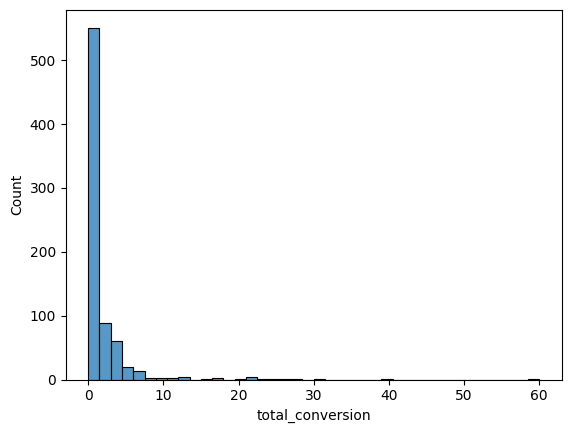

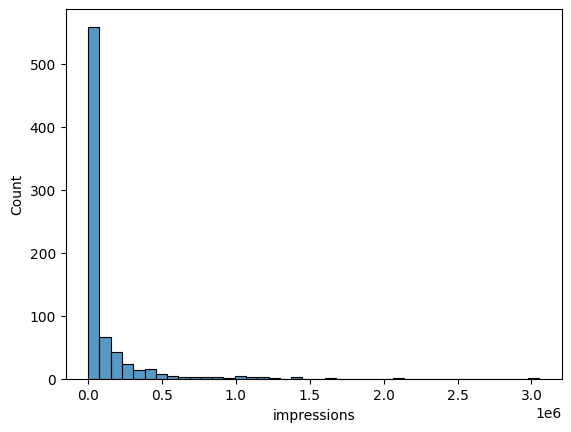

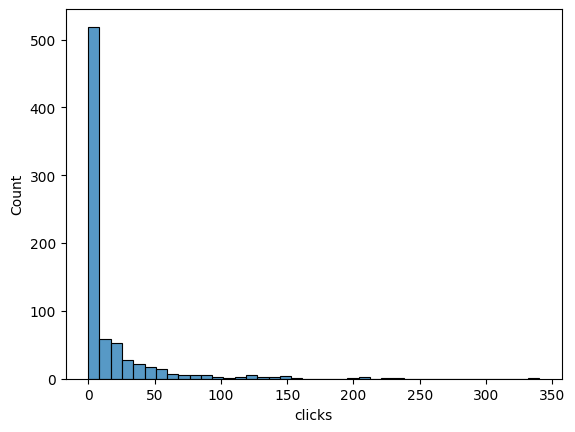

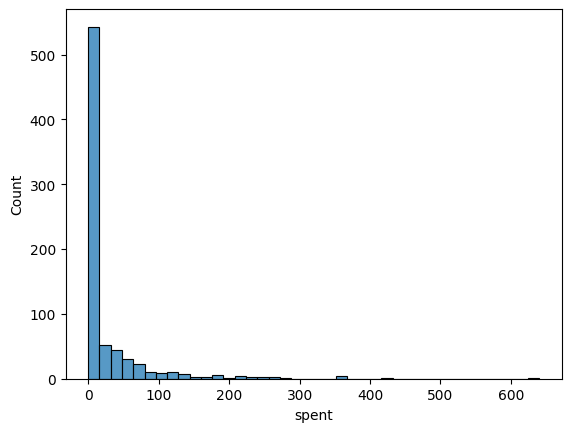

,spent,impressions,clicks,total_conversion
count,761.000000,7.610000e+02,761.000000,761.000000
mean,25.782181,1.031716e+05,15.834428,2.161629
std,57.622334,2.462644e+05,32.568655,4.062201
min,0.000000,8.700000e+01,0.000000,0.000000
25%,0.000000,3.149000e+03,1.000000,1.000000
50%,3.580000,1.219300e+04,3.000000,1.000000
75%,23.210000,8.597000e+04,15.000000,2.000000
max,639.949998,3.052003e+06,340.000000,60.000000


In [35]:
sns.histplot(final_df, x = "total_conversion", bins=40)
plt.show()
sns.histplot(final_df, x = "impressions", bins=40)
plt.show()
sns.histplot(final_df, x = "clicks", bins=40)
plt.show()
sns.histplot(final_df, x = "spent", bins=40)
plt.show()
final_df[["spent", "impressions", "clicks", "total_conversion"]].describe()

As we can see that all three distribution are right skewed.

What this means in terms of the clicks and total_conversion is that there are more cases of ads with less clicks and coversions than those with higher engagement. We can see that numerically in the describe output that for clicks the median was 3, mean was ~15 and max was 340 which means there are more ads with small amounts of engagement than those with higher amounts of engagement.

For spent, it was more likely the ad was funded with a small bugdet then for impressions it was more likely an ad had a small amount of viewing relatively compared to others.


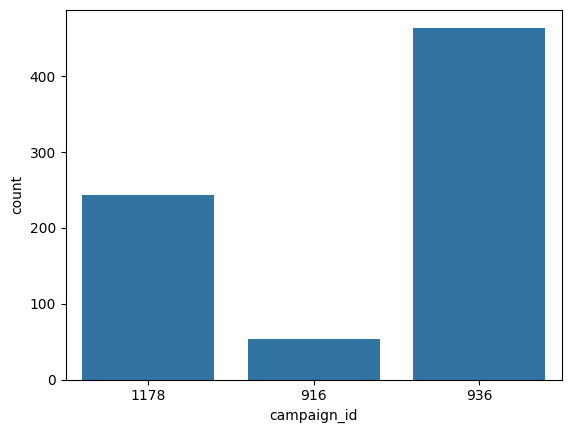

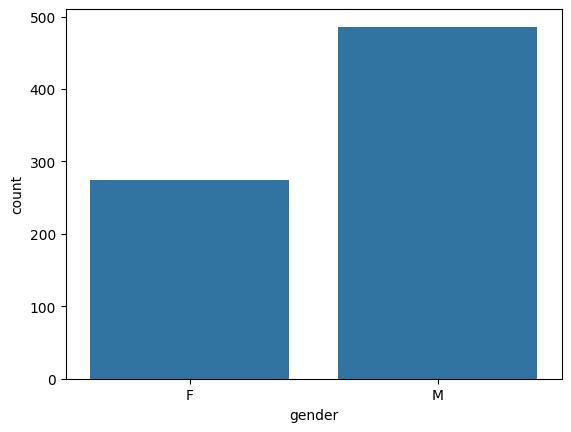

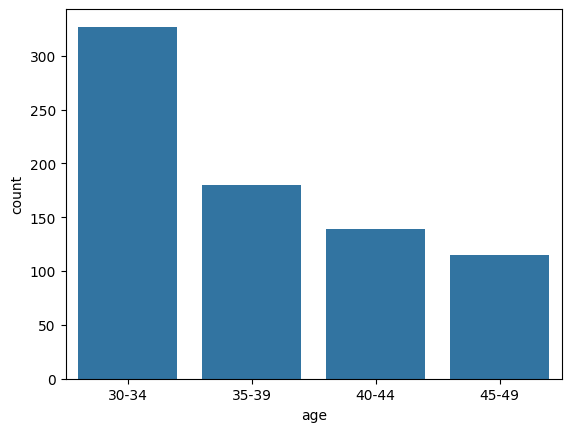

In [36]:
query1 = "SELECT campaign_id, COUNT(*) AS count FROM final_df GROUP BY campaign_id;"
campaign_cnt = psql.sqldf(query1, locals()) 
sns.barplot(campaign_cnt, y = "count", x = "campaign_id")
plt.show()

query2 = "SELECT gender, COUNT(*) AS count FROM final_df GROUP BY gender;"
campaign_cnt = psql.sqldf(query2, locals()) 
sns.barplot(campaign_cnt, y = "count", x = "gender")
plt.show()

query3 = "SELECT age, COUNT(*) AS count FROM final_df GROUP BY age;"
campaign_cnt = psql.sqldf(query3, locals()) 
sns.barplot(campaign_cnt, y = "count", x = "age")
plt.show()

We can see that campaign 936 has a lot of ads while campaign 916 has a very small amount of ads, when compared to the rest of the campaigns.

Additionally it seems like the campaigns targeted their ads more towards men than women

Also we can see that there is decline of the amount of ads as we increase the age range, signifying that the campaigns most likely targetted younger folk.

### checking distribution, clustered by campgaign id

In [37]:
def make_campaign_histplots(df, feature):
    #PLZ DOC THIS
    sns.histplot(df, x=feature, bins = 25, hue = "campaign_id")
    plt.show()
    lst_id = np.unique(df["campaign_id"].to_numpy())
    for id in lst_id:
        curr_id_df = df[df["campaign_id"] == id]
        print(f"Campign{id} {feature} summary")
        print(curr_id_df[feature].describe(percentiles= [.5]))
                     

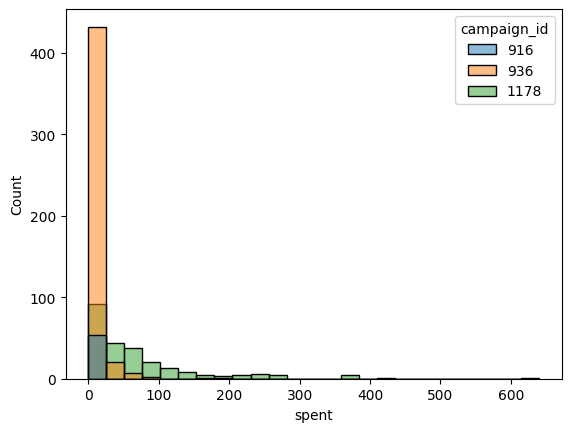

Campign1178 spent summary
count    243.000000
mean      68.218765
std       85.190852
min        0.000000
50%       38.440001
max      639.949998
Name: spent, dtype: float64
Campign916 spent summary
count    54.000000
mean      2.772407
std       3.990071
min       0.000000
50%       1.450000
max      18.070000
Name: spent, dtype: float64
Campign936 spent summary
count    464.000000
mean       6.235711
std       16.287179
min        0.000000
50%        1.385000
max      180.220001
Name: spent, dtype: float64


In [38]:
make_campaign_histplots(final_df, "spent")  

We can see that on average Campaign 1178 spent more on their ads than the other two campaigns combined, while campaign 936 spent the least on average.

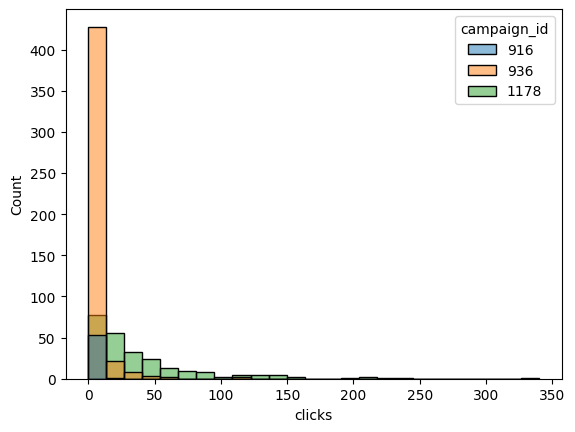

Campign1178 clicks summary
count    243.000000
mean      40.168724
std       47.338245
min        1.000000
50%       23.000000
max      340.000000
Name: clicks, dtype: float64
Campign916 clicks summary
count    54.000000
mean      2.444444
std       2.799371
min       1.000000
50%       1.000000
max      14.000000
Name: clicks, dtype: float64
Campign936 clicks summary
count    464.000000
mean       4.648707
std       10.577059
min        0.000000
50%        1.000000
max      116.000000
Name: clicks, dtype: float64


In [39]:
make_campaign_histplots(final_df, "clicks")  

Here we can see the same pattern of campaign 1178 having the higher amount of clicks on average, more than the other two combined. While the campign with the least amount of clicks on average would be campaign 916

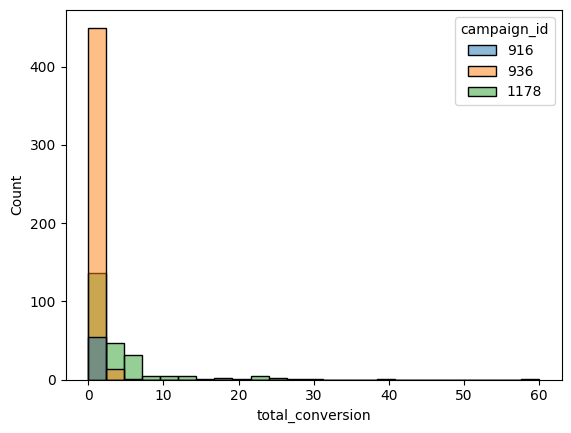

Campign1178 total_conversion summary
count    243.000000
mean       4.320988
std        6.663383
min        0.000000
50%        2.000000
max       60.000000
Name: total_conversion, dtype: float64
Campign916 total_conversion summary
count    54.000000
mean      1.074074
std       0.264351
min       1.000000
50%       1.000000
max       2.000000
Name: total_conversion, dtype: float64
Campign936 total_conversion summary
count    464.000000
mean       1.157328
std        0.524796
min        0.000000
50%        1.000000
max        5.000000
Name: total_conversion, dtype: float64


In [40]:
make_campaign_histplots(final_df, "total_conversion")  

We again see the same theme of campign 1178 having the higher amount of total conversions on average, more than the other two combined. In this feature both campign 916 and 936 had around the same amount of converions on average.

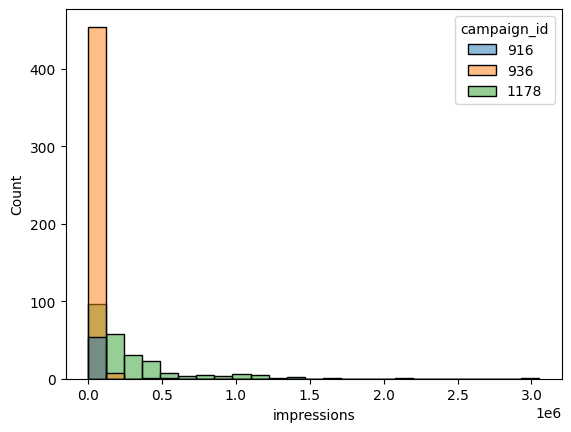

Campign1178 impressions summary
count    2.430000e+02
mean     2.876645e+05
std      3.700169e+05
min      7.073000e+03
50%      1.712020e+05
max      3.052003e+06
Name: impressions, dtype: float64
Campign916 impressions summary
count       54.000000
mean      8943.055556
std      11555.813220
min        292.000000
50%       4443.000000
max      57665.000000
Name: impressions, dtype: float64
Campign936 impressions summary
count       464.000000
mean      17517.644397
std       41472.794907
min          87.000000
50%        5589.000000
max      493821.000000
Name: impressions, dtype: float64


In [41]:
make_campaign_histplots(final_df, "impressions")  

We see campaign 1178 having the higher amount of impressions on average, more than the other two combined. While campign 916 has the smaller amount of impressions on average.

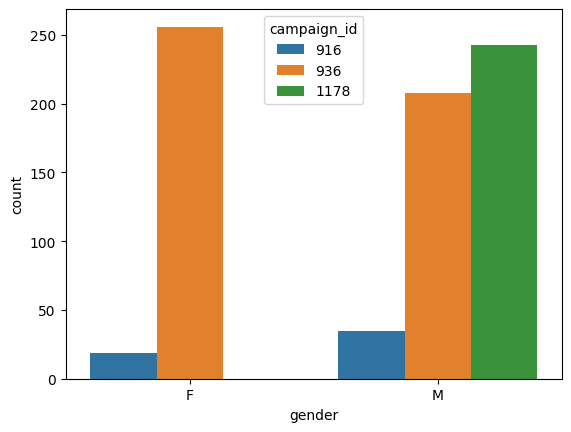

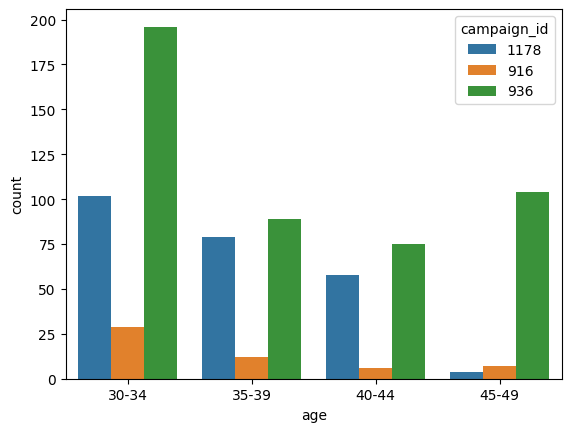

In [43]:
query1 = "SELECT campaign_id, gender, COUNT(*) AS count FROM final_df GROUP BY gender, campaign_id;"
campaign_gender_cnt = psql.sqldf(query1, locals()) 
sns.barplot(campaign_gender_cnt, y = "count", x = "gender", hue= "campaign_id")
plt.show()

query2 = "SELECT campaign_id, age, COUNT(*) AS count FROM final_df GROUP BY age, campaign_id;"
campaign_age_cnt = psql.sqldf(query2, locals()) 
sns.barplot(campaign_age_cnt, y = "count", x = "age", hue= "campaign_id")
plt.show()

We see that campign 1178 seem to soley focus their ads towards men, seemly having 0 ads targeted towards women. While campaign 936 having a tiny bit more ads targeted towards women than men.

Campign 1178 and 916 seems to have the steady decline of ads as we move up the age range, 1178 has a big decrease in ads targeted towards the older audience. We see 936 favoring the younger audience more than the other age groups.

### checking numerical distribution, clustered by aged

In [44]:
def make_age_histplots(df, feature):
    #PLZ DOC THIS

    sns.histplot(df, x=feature, bins = 25, hue = "age")
    plt.show()
    lst_ages = np.unique(df["age"].to_numpy())
    for age in lst_ages:
        curr_age_df = df[df["age"] == age]
        print(f"Age Group:{age} {feature} distribution")
        print(curr_age_df[feature].describe(percentiles= [.5]))

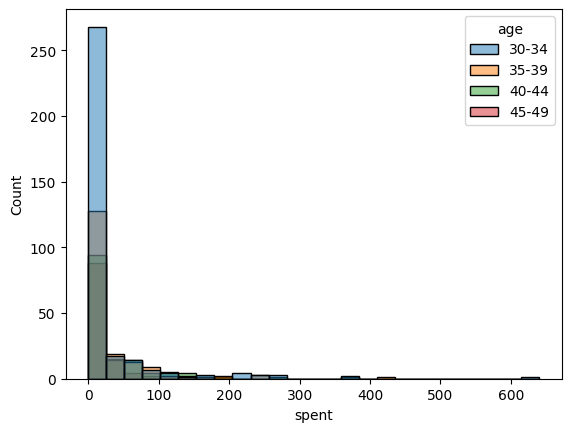

Age Group:30-34 spent distribution
count    327.000000
mean      23.526667
std       64.396567
min        0.000000
50%        1.560000
max      639.949998
Name: spent, dtype: float64
Age Group:35-39 spent distribution
count    180.000000
mean      28.586222
std       54.776834
min        0.000000
50%        4.215000
max      420.579998
Name: spent, dtype: float64
Age Group:40-44 spent distribution
count    139.000000
mean      31.205971
std       52.458628
min        0.000000
50%        7.720000
max      359.470000
Name: spent, dtype: float64
Age Group:45-49 spent distribution
count    115.000000
mean      21.251043
std       46.375295
min        0.000000
50%        4.590000
max      365.660001
Name: spent, dtype: float64


In [147]:
make_age_histplots(final_df, "spent")

We can see that the distribution of the histogram across ages are very similar. As we can see in the desrcribe output the means of each distribution are relatively the same, comparing the distances between the means with the standard deviation. We can infer that the campaigns did not take into consideration the age of the audience when deciding how much to spend. 

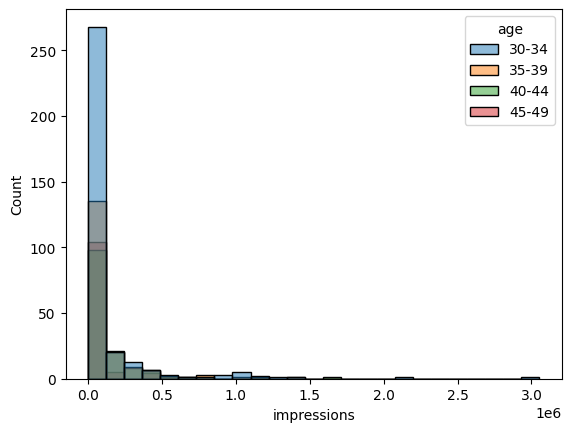

Age Group:30-34 impressions distribution
count    3.270000e+02
mean     1.091088e+05
std      2.979596e+05
min      1.520000e+02
50%      8.817000e+03
max      3.052003e+06
Name: impressions, dtype: float64
Age Group:35-39 impressions distribution
count    1.800000e+02
mean     1.120299e+05
std      2.136301e+05
min      2.390000e+02
50%      1.509150e+04
max      1.447755e+06
Name: impressions, dtype: float64
Age Group:40-44 impressions distribution
count    1.390000e+02
mean     1.142560e+05
std      2.144397e+05
min      8.700000e+01
50%      2.381700e+04
max      1.663441e+06
Name: impressions, dtype: float64
Age Group:45-49 impressions distribution
count    1.150000e+02
mean     5.902634e+04
std      1.440928e+05
min      2.550000e+02
50%      1.119900e+04
max      1.177535e+06
Name: impressions, dtype: float64


In [146]:
make_age_histplots(final_df, "impressions")

We can for all the ages groups, minus 45-49, that the average impressions were in the 100,0000 while for the group 45-49 their average was in the 10,000. Comparing the standard deviations of the age group of 45-49 to the difference of means it does equal around the SD. Gives evidence that perhaps the campaigns on averages showed less ads to the age group of 45-49 compared to other age groups.

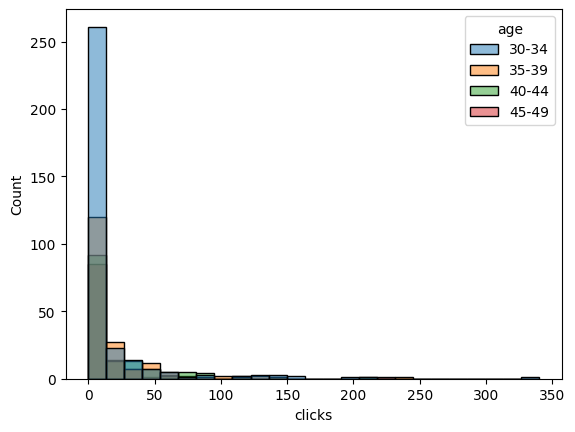

Age Group:30-34 clicks distribution
count    327.000000
mean      14.241590
std       35.599421
min        0.000000
50%        1.000000
max      340.000000
Name: clicks, dtype: float64
Age Group:35-39 clicks distribution
count    180.000000
mean      17.133333
std       30.533506
min        0.000000
50%        4.000000
max      233.000000
Name: clicks, dtype: float64
Age Group:40-44 clicks distribution
count    139.000000
mean      19.460432
std       30.734314
min        1.000000
50%        5.000000
max      205.000000
Name: clicks, dtype: float64
Age Group:45-49 clicks distribution
count    115.000000
mean      13.947826
std       28.468771
min        1.000000
50%        3.000000
max      221.000000
Name: clicks, dtype: float64


In [139]:
make_age_histplots(final_df, "clicks")

Looking at the averages it appears to be that they are around the same. The histrogram distributions between the age groups looks relatively the same. This gives evidence that on average an ad for any campaign would get the same amount of clicks from each age group. Therefore age should not be a big factor when constructing a campign.

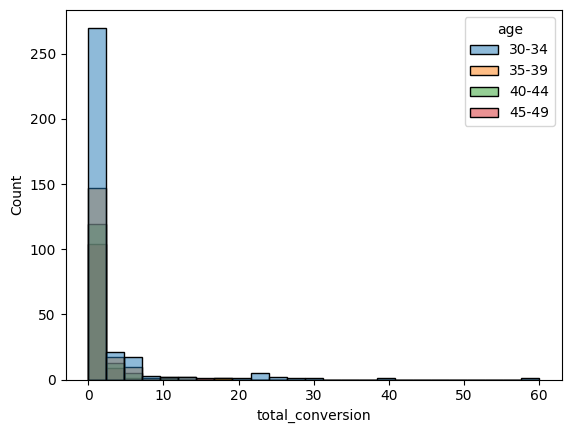

Age Group:30-34 total_conversion distribution
count    327.000000
mean       2.721713
std        5.706974
min        0.000000
50%        1.000000
max       60.000000
Name: total_conversion, dtype: float64
Age Group:35-39 total_conversion distribution
count    180.000000
mean       1.983333
std        2.329013
min        0.000000
50%        1.000000
max       17.000000
Name: total_conversion, dtype: float64
Age Group:40-44 total_conversion distribution
count    139.000000
mean       1.690647
std        1.899080
min        1.000000
50%        1.000000
max       17.000000
Name: total_conversion, dtype: float64
Age Group:45-49 total_conversion distribution
count    115.000000
mean       1.417391
std        1.486681
min        1.000000
50%        1.000000
max       15.000000
Name: total_conversion, dtype: float64


In [148]:
make_age_histplots(final_df, "total_conversion")

We can see almost the same pattern that on average each age group has the same amount of conversions. However we do see that for the youngest age group, 30-34, it has higher extremes than the other groups making it more right skewed than the other histograms. Thus it can be that on extreme cases the youngest group has a higher total conversion compared to the other age groups. 

### checking numerical distribution, clustered by gender

In [49]:
def make_gender_histplots(df, feature):
    #PLZ DOC THIS

    sns.histplot(df, x=feature, bins = 25, hue = "gender")
    plt.show()
    
    lst_genders = np.unique(df["gender"].to_numpy())
    for gender in lst_genders:
        curr_gender_df = df[df["gender"] == gender]
        print(f"Gender Group:{gender} {feature} summary")
        print(curr_gender_df[feature].describe(percentiles = [.5]))

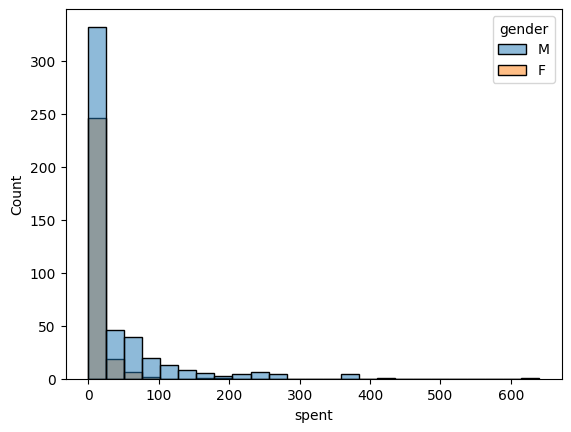

Gender Group:F spent summary
count    275.000000
mean       8.909855
std       20.101617
min        0.000000
50%        1.640000
max      180.220001
Name: spent, dtype: float64
Gender Group:M spent summary
count    486.000000
mean      35.329280
std       68.716564
min        0.000000
50%        4.955000
max      639.949998
Name: spent, dtype: float64


In [50]:
make_gender_histplots(final_df, "spent")

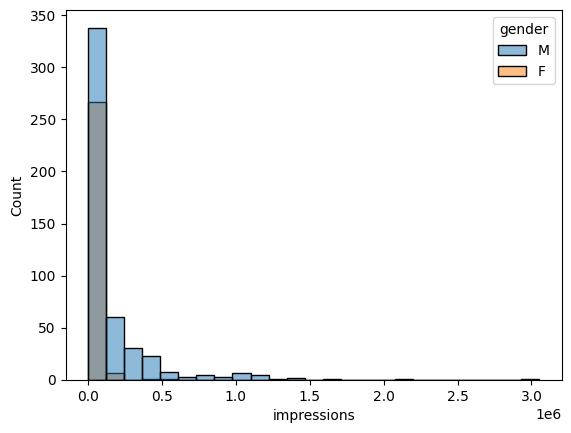

Gender Group:F impressions summary
count       275.000000
mean      23590.134545
std       50913.917131
min          87.000000
50%        6585.000000
max      493821.000000
Name: impressions, dtype: float64
Gender Group:M impressions summary
count    4.860000e+02
mean     1.482023e+05
std      2.965564e+05
min      1.520000e+02
50%      2.267100e+04
max      3.052003e+06
Name: impressions, dtype: float64


In [51]:
make_gender_histplots(final_df, "impressions")

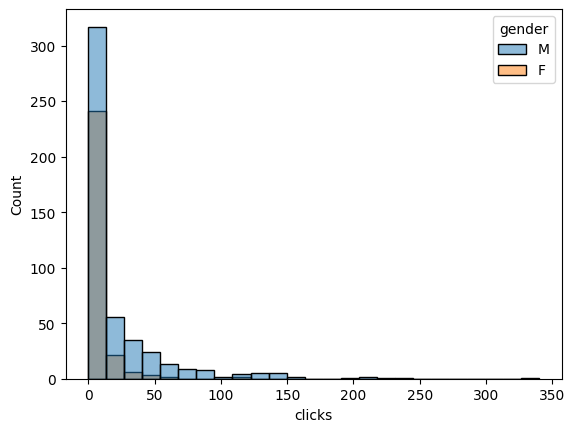

Gender Group:F clicks summary
count    275.000000
mean       6.421818
std       13.149210
min        0.000000
50%        1.000000
max      116.000000
Name: clicks, dtype: float64
Gender Group:M clicks summary
count    486.000000
mean      21.160494
std       38.546250
min        1.000000
50%        4.000000
max      340.000000
Name: clicks, dtype: float64


In [52]:
make_gender_histplots(final_df, "clicks")

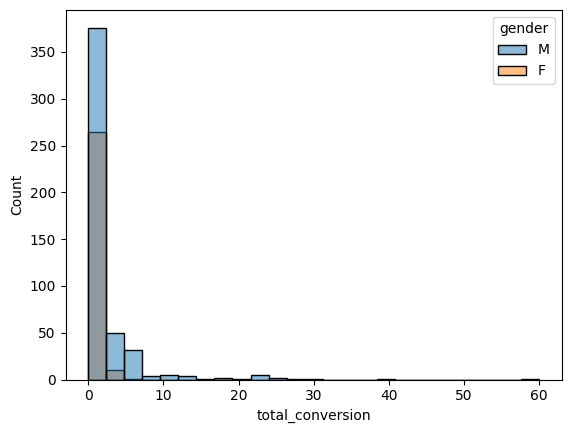

Gender Group:F total_conversion summary
count    275.000000
mean       1.170909
std        0.582492
min        0.000000
50%        1.000000
max        5.000000
Name: total_conversion, dtype: float64
Gender Group:M total_conversion summary
count    486.000000
mean       2.722222
std        4.979442
min        0.000000
50%        1.000000
max       60.000000
Name: total_conversion, dtype: float64


In [53]:
make_gender_histplots(final_df, "total_conversion")

We can see the consistent pattern between all features that on averages males have higher totals than females. It is also consistent the difference between means was around 1SD(females), giving more evidence that ads targetted to males either have higher budget, showing or engagement than ads targetted to females.

## Data Engineering

We will use three features/KPIS to test which campaigns are better.

clickThroughRate (ctr) which shows how many clicks per impressions does each ad get. The higher the number the more likely the campaign compelled the auidence to learn more.

conversion rate (cr) which shows how many conversions per impression each ad gets. The higher the number the more likely the campign convinced the user to download

CostPerClick(cpc) whichs show how much the campign spent to earn one click. The higher the number means it was expensive to get a click. It was expensive to get a form of engagement.

In [54]:
query = "SELECT *, clicks / impressions AS ctr, total_conversion /  impressions AS cr, spent / clicks AS cpc FROM final_df;"
kpi_df = psql.sqldf(query, locals())
kpi_df

,campaign_id,age,gender,impressions,clicks,spent,total_conversion,ctr,cr,cpc
0,916,30-34,M,7350.0,1,1.430000,2.0,0.000136,0.000272,1.430000
1,916,30-34,M,17861.0,2,1.820000,2.0,0.000112,0.000112,0.910000
2,916,30-34,M,693.0,1,0.000000,1.0,0.001443,0.001443,0.000000
3,916,30-34,M,4259.0,1,1.250000,1.0,0.000235,0.000235,1.250000
4,916,30-34,M,4133.0,1,1.290000,1.0,0.000242,0.000242,1.290000
...,...,...,...,...,...,...,...,...,...,...
756,1178,40-44,M,9773.0,1,1.460000,1.0,0.000102,0.000102,1.460000
757,1178,45-49,M,464036.0,77,123.550000,3.0,0.000166,0.000006,1.604545
758,1178,45-49,M,478480.0,75,135.750001,3.0,0.000157,0.000006,1.810000
759,1178,45-49,M,428812.0,66,116.880000,4.0,0.000154,0.000009,1.770909


In [114]:
kpi_df.isna().sum()

campaign_id         0
age                 0
gender              0
impressions         0
clicks              0
spent               0
total_conversion    0
ctr                 0
cr                  0
cpc                 3
dtype: int64

In [115]:
kpi_df[kpi_df["cpc"].isna()]

,campaign_id,age,gender,impressions,clicks,spent,total_conversion,ctr,cr,cpc
95,936,35-39,F,652.0,0,0.0,0.0,0.0,0.0,NaN
184,936,35-39,F,512.0,0,0.0,0.0,0.0,0.0,NaN
510,936,30-34,F,529.0,0,0.0,0.0,0.0,0.0,NaN


We can see that the only Nan values are when both spent and clicks are equal 0. Thus we can change those Nan values to 0.

In [117]:
kpi_df.loc[:,"cpc"] = kpi_df["cpc"].fillna(0)
kpi_df.isna().sum()

campaign_id         0
age                 0
gender              0
impressions         0
clicks              0
spent               0
total_conversion    0
ctr                 0
cr                  0
cpc                 0
dtype: int64

### checking the kpi distribution individualy 

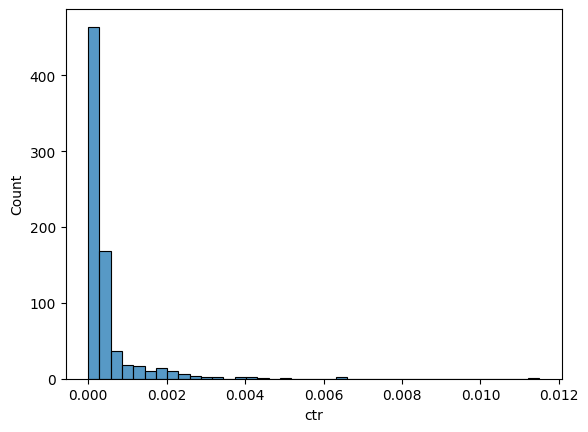

count    761.000000
mean       0.000470
std        0.000802
min        0.000000
25%        0.000146
50%        0.000229
75%        0.000387
max        0.011494
Name: ctr, dtype: float64


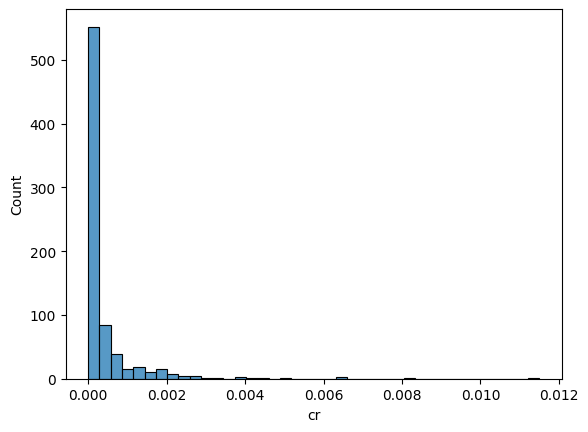

count    761.000000
mean       0.000470
std        0.000802
min        0.000000
25%        0.000146
50%        0.000229
75%        0.000387
max        0.011494
Name: ctr, dtype: float64


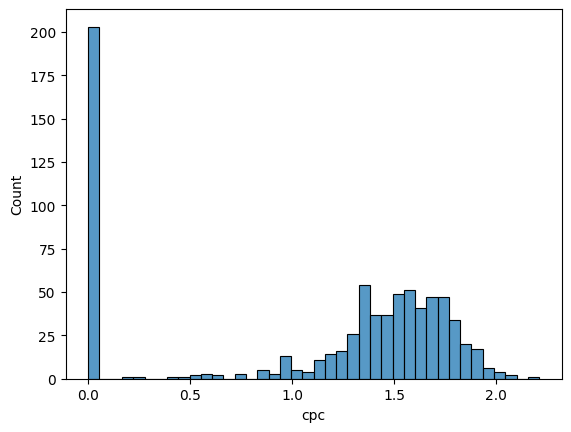

count    761.000000
mean       0.000470
std        0.000802
min        0.000000
25%        0.000146
50%        0.000229
75%        0.000387
max        0.011494
Name: ctr, dtype: float64


In [118]:
sns.histplot(kpi_df, x = "ctr", bins = 40)
plt.show()
print(kpi_df["ctr"].describe())

sns.histplot(kpi_df, x = "cr", bins = 40)
plt.show()
print(kpi_df["ctr"].describe())

sns.histplot(kpi_df, x = "cpc", bins = 40)
plt.show()
print(kpi_df["ctr"].describe())

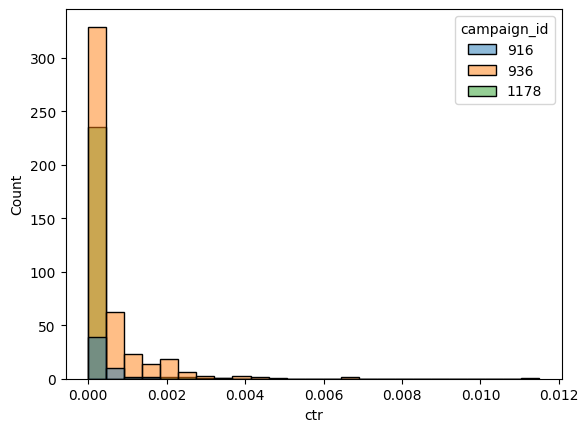

Campign1178 ctr summary
count    243.000000
mean       0.000202
std        0.000396
min        0.000031
50%        0.000138
max        0.003252
Name: ctr, dtype: float64
Campign916 ctr summary
count    54.000000
mean      0.000496
std       0.000532
min       0.000091
50%       0.000332
max       0.003425
Name: ctr, dtype: float64
Campign936 ctr summary
count    464.000000
mean       0.000608
std        0.000941
min        0.000000
50%        0.000309
max        0.011494
Name: ctr, dtype: float64


In [119]:
make_campaign_histplots(kpi_df, "ctr")

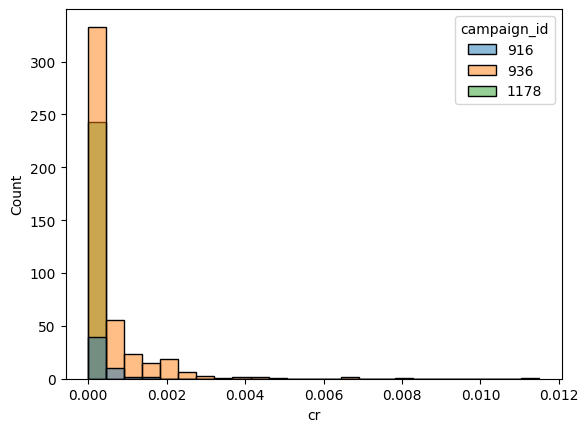

Campign1178 cr summary
count    243.000000
mean       0.000023
std        0.000024
min        0.000000
50%        0.000016
max        0.000141
Name: cr, dtype: float64
Campign916 cr summary
count    54.000000
mean      0.000433
std       0.000566
min       0.000017
50%       0.000238
max       0.003425
Name: cr, dtype: float64
Campign936 cr summary
count    464.000000
mean       0.000545
std        0.001025
min        0.000000
50%        0.000199
max        0.011494
Name: cr, dtype: float64


In [120]:
make_campaign_histplots(kpi_df, "cr")

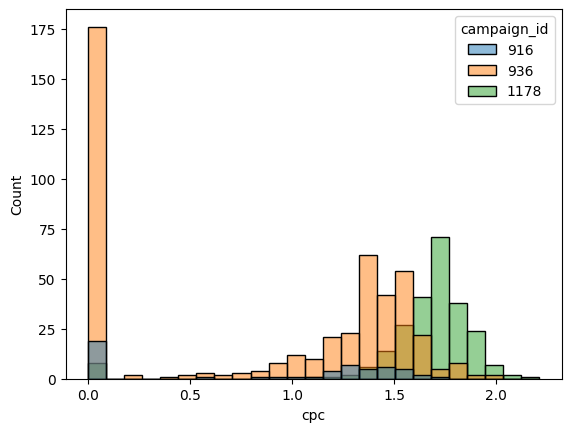

Campign1178 cpc summary
count    243.000000
mean       1.644663
std        0.339948
min        0.000000
50%        1.709500
max        2.212000
Name: cpc, dtype: float64
Campign916 cpc summary
count    54.000000
mean      0.862264
std       0.667510
min       0.000000
50%       1.215000
max       1.690000
Name: cpc, dtype: float64
Campign936 cpc summary
count    464.000000
mean       0.846742
std        0.697386
min        0.000000
50%        1.201111
max        2.013333
Name: cpc, dtype: float64


In [121]:
make_campaign_histplots(kpi_df, "cpc")

From the histograms we can that for cr and ctr on average campign 1178 had lower rates than campaign 936 or 916. Then for cpc it was seen on average campaign 1178 had a higher cpc than campaign 936 or 916.

For campaign 936 and 916 it seems like on average their rates and cpc was around the same.

This implies the campaign 1178 seem to preform worst than campaign 916 and 936 while 916 and 936 performed equally well.

# Hypothesis Testing

## check if the dists are normal

In [122]:
def checkNorm(df, feature):
    lst_ids = np.unique(df["campaign_id"])
    for id in lst_ids:
        curr_df = df[df["campaign_id"] == id]
        probplot(curr_df[feature], dist= "norm", plot = plt)
        plt.title(f"Campign{id} QQ plot for {feature}")
        plt.show()

We will use QQ plots to test normality. 

The feature follows a normal distribution only if the QQ plot shows a perfect straight line with a positive slope

Otherwise the feature does not follow a normal distribution 

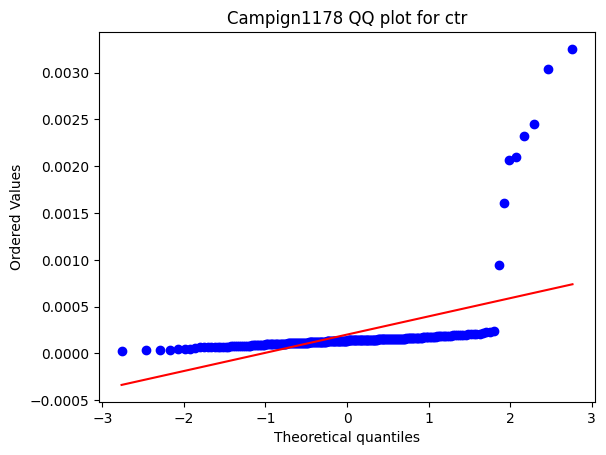

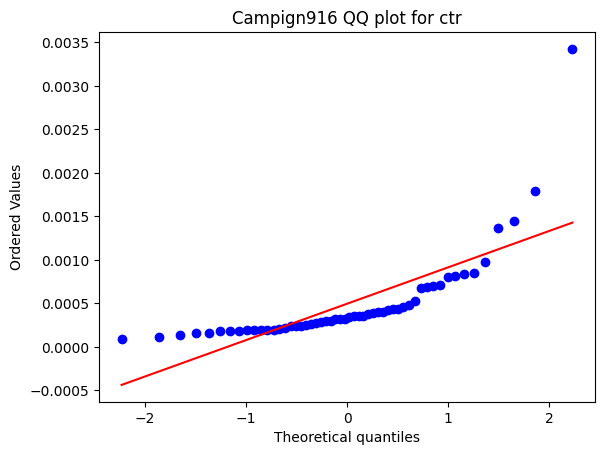

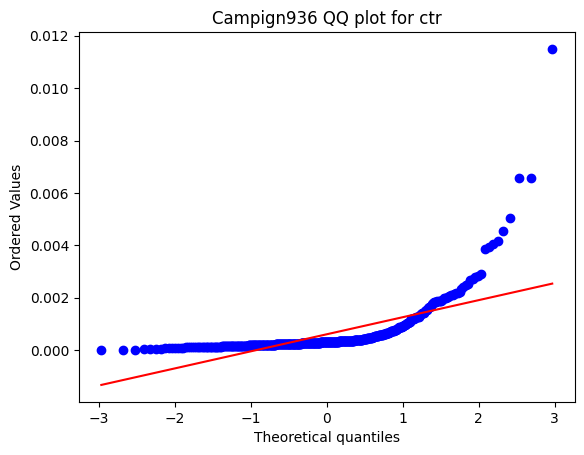

In [123]:
checkNorm(kpi_df, "ctr")

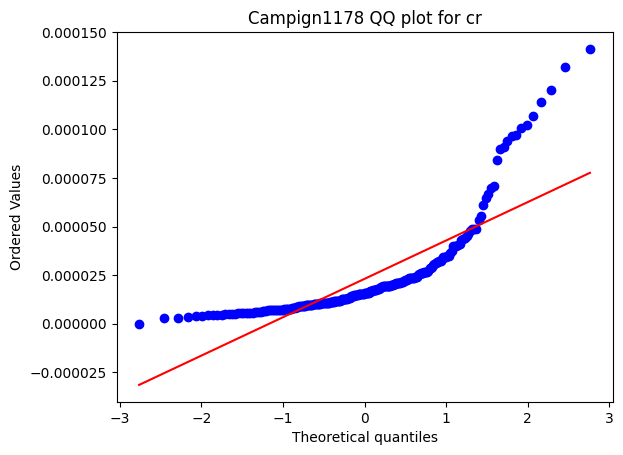

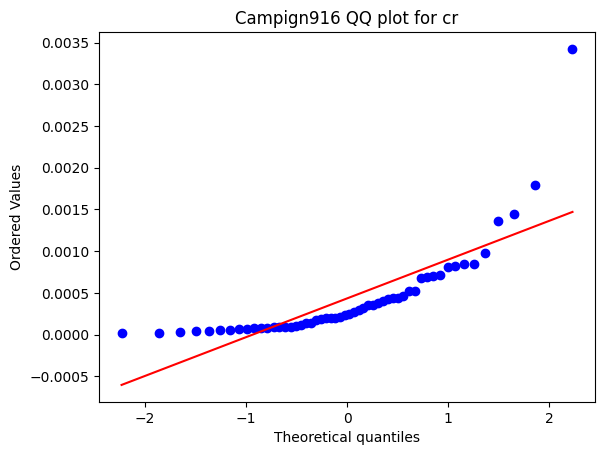

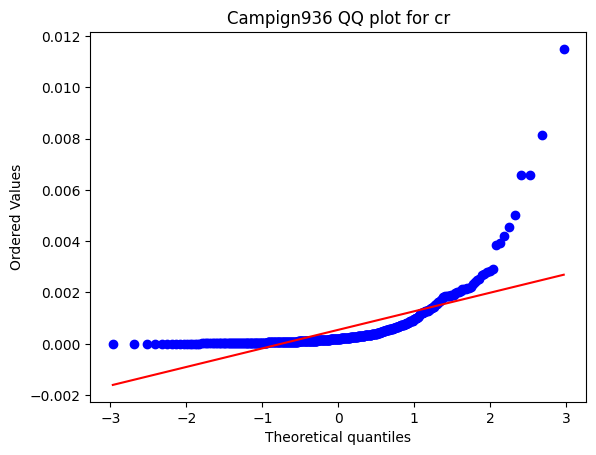

In [124]:
checkNorm(kpi_df, "cr")

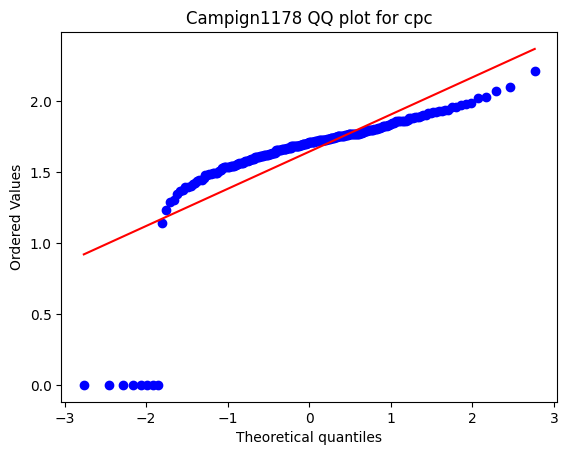

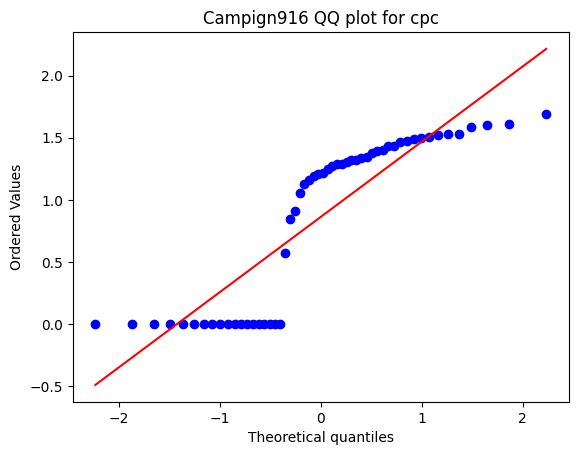

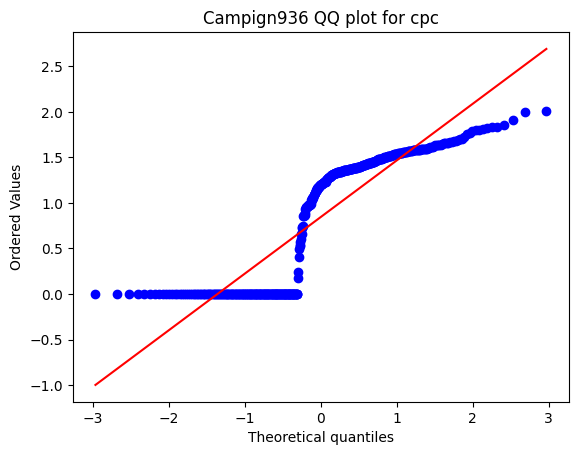

In [125]:
checkNorm(kpi_df, "cpc")

We can see that no plot follows a linear line with a positive slope thus we cannot assume normality for either campaign's feature plot

Thus for all hypothesis test we will be using the mannwhinteyU test which assumes the distributions of the groups dont follow a normal distribution. We will be using a significant level of 0.05 

**Null:** The feature distribution between the campaigns are similar and any difference is due to chance 

**Alt:** The distribution are not the same

In [126]:
campaign936_df = kpi_df[kpi_df["campaign_id"] == "936"]
campaign916_df = kpi_df[kpi_df["campaign_id"] == "916"]
campaign1178_df = kpi_df[kpi_df["campaign_id"] == "1178"]

In [127]:
_, pval = mannwhitneyu(campaign1178_df["ctr"], campaign916_df["ctr"])
print(f"ctr 1178 v 916 pval: {pval}")

_, pval = mannwhitneyu(campaign1178_df["ctr"], campaign936_df["ctr"])
print(f"ctr 1178 v 936 pval: {pval}")

_, pval = mannwhitneyu(campaign916_df["ctr"], campaign936_df["ctr"])
print(f"ctr 916 v 936 pval: {pval}")

ctr 1178 v 916 pval: 2.1897387290932014e-21
ctr 1178 v 936 pval: 3.8370378773273156e-66
ctr 916 v 936 pval: 0.7931294730833396


In [128]:
_, pval = mannwhitneyu(campaign1178_df["cr"], campaign916_df["cr"])
print(f"cr 1178 v 916 pval: {pval}")

_, pval = mannwhitneyu(campaign1178_df["cr"], campaign936_df["cr"])
print(f"cr 1178 v 936 pval: {pval}")

_, pval = mannwhitneyu(campaign916_df["cr"], campaign936_df["cr"])
print(f"cr 916 v 936 pval: {pval}")

cr 1178 v 916 pval: 1.2895665998643711e-26
cr 1178 v 936 pval: 4.018904166530784e-77
cr 916 v 936 pval: 0.4339652264015792


In [130]:
_, pval = mannwhitneyu(campaign1178_df["cpc"], campaign916_df["cpc"])
print(f"cpc 1178 v 916 pval: {pval}")

_, pval = mannwhitneyu(campaign1178_df["cpc"], campaign936_df["cpc"])
print(f"cr 1178 v 936 pval: {pval}")

_, pval = mannwhitneyu(campaign916_df["cpc"], campaign936_df["cpc"])
print(f"cr 916 v 936 pval: {pval}")

cpc 1178 v 916 pval: 2.403258515640343e-23
cr 1178 v 936 pval: 1.1405680811169264e-71
cr 916 v 936 pval: 0.7970274733773802


**CTR**
We can that for 1178 vs the other campagins we saw pvalue < 0.05 therefore we can reject the null. Therefore the ctr distributions are not the same.

For 916 vs 936 we saw a pval > 0.05 therefore we fail to reject the null

**CR**
We can that for 1178 vs the other campagins we saw pvalue < 0.05 therefore we can reject the null. Therefore the cr distributions are not the same.

For 916 vs 936 we saw a pval > 0.05 therefore we fail to reject the null.


**CPC**
We can that for 1178 vs the other campagins we saw pvalue < 0.05 therefore we can reject the null. Therefore the cpc distributions are not the same.

For 916 vs 936 we saw a pval > 0.05 therefore we fail to reject the null.

We can see that there is evidence that the distributions for campaign 1178 is different than the other two. Previously we saw that on average 1178 ctr and cr were smaller than 916 and 936 plus cpc was higher than 916 and 936. So we can run the same test to see if our previous findings hold. 

**Null:** The feature distribution between the campaigns are similar and any difference is due to chance 

**Alt:** Campign 1178 has a lower ctr/cr on average than the other two campaigns

In [132]:
_, pval = mannwhitneyu(campaign1178_df["ctr"], campaign916_df["ctr"], alternative= "less")
print(f"ctr 1178 v 916 pval: {pval}")

_, pval = mannwhitneyu(campaign1178_df["ctr"], campaign936_df["ctr"],alternative= "less")
print(f"ctr 1178 v 936 pval: {pval}")

ctr 1178 v 916 pval: 1.0948693645466007e-21
ctr 1178 v 936 pval: 1.9185189386636578e-66


In [133]:
_, pval = mannwhitneyu(campaign1178_df["cr"], campaign916_df["cr"], alternative= "less")
print(f"cr 1178 v 916 pval: {pval}")

_, pval = mannwhitneyu(campaign1178_df["cr"], campaign936_df["cr"],alternative= "less")
print(f"cr 1178 v 936 pval: {pval}")

ctr 1178 v 916 pval: 6.4478329993218555e-27
ctr 1178 v 936 pval: 2.009452083265392e-77


**Null:** The feature distribution between the campaigns are similar and any difference is due to chance 

**Alt:** Campign 1178 has a higher cpc on average than the other two campaigns

In [136]:
_, pval = mannwhitneyu(campaign1178_df["cpc"], campaign916_df["cpc"], alternative= "greater")
print(f"cpc 1178 v 916 pval: {pval}")

_, pval = mannwhitneyu(campaign1178_df["cpc"], campaign936_df["cpc"],alternative= "greater")
print(f"cpc 1178 v 936 pval: {pval}")

cpc 1178 v 916 pval: 1.2016292578201715e-23
cpc 1178 v 936 pval: 5.702840405584632e-72


**CTR**
We can that for 1178 vs the other campagins we saw pvalue < 0.05 therefore we can reject the null. Therefore on average the ctr of campaigns 1178 are lower than both the ctr of campaigns 916 and 936.


**CR**
We can that for 1178 vs the other campagins we saw pvalue < 0.05 therefore we can reject the null. Therefore on average the cr of campaigns 1178 are lower than both cr of campaign 916 and 936.


**CPC**
We can that for 1178 vs the other campagins we saw pvalue < 0.05 therefore we can reject the null. Therefore on average the cpc of campign 1178 was higher than the cpc of both campagin 916 and 936


From running the above hypothesis we can determine there is evidence supporting the hypothesis that campaign 1178 is performing worse than campaign 916 and 936. There is evidence that campagin 916 and 936 has a higher cr and ctr and a smaller cpc than 1178 on average it is clear to see that 916 and 936 
are more cost-effective.

Therefore we should priortize investing in campaigns 916 and 936. It is relevant to point that the number of ads in campaign 916 is low, so the company should be wary about not investing too much given it is unpredictable on well it preforms on a larger scale. So since there is no evidence to support campaign 916 is better or worse than 936 it might be safer to invest in 936, given it already has a large ad size.